## 1... Install required packages

In [ ]:
!pip install torch
!pip install torchinfo

## 2... Navigate to the correct path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/MyDrive/FYP_ECG"

/content/gdrive/MyDrive/FYP_ECG


## 3... Import required libraries

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/FYP_ECG/')

import numpy as np
import pickle
import fyp2_model_network_architecture
from fyp2_model_network_architecture import *
import copy
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader

import collections
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 4... Define all helper functions for training, validating and testing

### 4.1 Transformation to dataloader

In [ ]:
def transform(heartbeats_train,heartbeats_test,labels_train,labels_test,batchfirst=True,batch_size=64):

  if batchfirst == False:
    X_train = [data.reshape(1,-1) for data in heartbeats_train]
    X_test = [data.reshape(1,-1) for data in heartbeats_test]
  else:
    X_train = [data.reshape(-1,1) for data in heartbeats_train]
    X_test = [data.reshape(-1,1) for data in heartbeats_test]

  X_train = [torch.tensor(data, dtype=torch.float32) for data in X_train]
  X_test = [torch.tensor(data, dtype=torch.float32) for data in X_test]

  X_train = torch.stack(X_train)
  X_test = torch.stack(X_test)

  y_train = torch.tensor(labels_train)
  y_test = torch.tensor(labels_test)

  trainset = TensorDataset(X_train, y_train)
  testset = TensorDataset(X_test, y_test)

  # Create DataLoader for training and testing data
  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(testset, batch_size=batch_size,shuffle=True)

  for i,(data, targets) in enumerate(train_loader):
    print(f"(Trainset) Data shape: {data.shape}, targets shape: {targets.shape}")
    break  # Remove this break to print shapes for all batches

  for i,(data, targets) in enumerate(test_loader):
    print(f"(Testset) Data shape: {data.shape}, targets shape: {targets.shape}")
    break  # Remove this break to print shapes for all batches

  return train_loader,test_loader

### 4.2 Performance Metrics

In [ ]:
def get_accuracy(prediction, label):
    batch_size = len(prediction)
    prediction = prediction.detach()
    predicted_classes = (prediction >= 0.5).int()
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def get_precision(prediction, label):
    prediction = prediction.detach()
    predicted_classes = (prediction >= 0.5).int()
    true_positives = (predicted_classes.bool() & label.bool()).sum()
    predicted_positives = predicted_classes.sum()
    precision = true_positives.float() / (predicted_positives.float() + 1e-12)  # Add epsilon to avoid division by zero
    return precision

def get_recall(prediction, label):
    prediction = prediction.detach()
    predicted_classes = (prediction >= 0.5).int()
    label = label.int()
    true_positives = (predicted_classes & label).sum()
    actual_positives = label.sum()
    recall = true_positives / (actual_positives + 1e-12)  # Add epsilon to avoid division by zero
    return recall

def get_f1_score(prediction, label):
    precision = get_precision(prediction, label)
    recall = get_recall(prediction, label)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-12)  # Add epsilon to avoid division by zero
    return f1_score

### 4.3 Training loop

In [ ]:
def train_one_epoch(dataloader, model, criterion, optimizer, device,unsqueeze=False,max_norm = 1.0):
    y_true_train = []
    y_pred_train = []
    model.train()
    batch_losses = []
    batch_accs = []
    batch_precisions = []
    batch_recalls = []
    batch_f1_scores = []

    for inputs, labels in dataloader:

        inputs = inputs.to(device)
        labels = labels.float().to(device)

        if unsqueeze ==True:
          labels = labels.unsqueeze(1)

        # perform forward propagation
        prediction = model(inputs)

        prediction = torch.clamp(prediction, 0, 1)

        # compute loss and accuracy

        loss = criterion(prediction, labels)

        accuracy = get_accuracy(prediction, labels)
        precision = get_precision(prediction, labels)
        recall = get_recall(prediction, labels)
        f1_score = get_f1_score(prediction, labels)

        predicted_class = (prediction >= 0.5).int()

        y_true_train.append(labels.to('cpu').numpy())
        y_pred_train.append(predicted_class.to('cpu').numpy())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

        # update parameters
        optimizer.step()

        # save result
        batch_losses.append(loss.item())
        batch_accs.append(accuracy.item())
        batch_precisions.append(precision.item())
        batch_recalls.append(recall.item())
        batch_f1_scores.append(f1_score.item())

    y_true_train = np.concatenate(y_true_train)
    y_pred_train = np.concatenate(y_pred_train)

    return np.mean(batch_losses), np.mean(batch_accs), np.mean(batch_precisions), np.mean(batch_recalls), np.mean(batch_f1_scores), y_true_train, y_pred_train

### 4.4 Early Stopping Mechanism

In [ ]:
class EarlyStopping_ValLoss:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):

        """
        Early stopping to stop training when the validation loss does not improve.
        Args:
        - patience (int): How many epochs to wait after last time validation loss improved.
        - min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        - restore_best_weights (bool): Whether to restore model weights from the epoch with the best validation loss.
        """

        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.best_model_weights = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_weights = model.state_dict() if self.restore_best_weights else None
            self.counter = 0  # reset counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_weights(self, model):
        if self.restore_best_weights and self.best_model_weights is not None:
            model.load_state_dict(self.best_model_weights)

In [ ]:
class EarlyStopping_ValAcc:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):

        """
        Early stopping to stop training when the validation loss does not improve.
        Args:
        - patience (int): How many epochs to wait after last time validation loss improved.
        - min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        - restore_best_weights (bool): Whether to restore model weights from the epoch with the best validation loss.
        """

        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_acc = -float('inf')
        self.best_model_weights = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_acc, model):
        if val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.best_model_weights = model.state_dict() if self.restore_best_weights else None
            self.counter = 0  # reset counter if validation loss improves
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_weights(self, model):
        if self.restore_best_weights and self.best_model_weights is not None:
            model.load_state_dict(self.best_model_weights)

### 4.5 Testing loop

In [ ]:
def evaluate(dataloader, model, criterion, device,unsqueeze = False):
    y_true_test = []
    y_pred_test = []
    model.eval()
    batch_losses = []
    batch_accs = []
    batch_precisions = []
    batch_recalls = []
    batch_f1_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:

            inputs = inputs.to(device)
            labels = labels.float().to(device)
            if unsqueeze ==True:
              labels = labels.unsqueeze(1)

            # forward propagation
            prediction = model(inputs)
            prediction = torch.clamp(prediction, 0, 1)

            # compute loss and accuracy
            loss = criterion(prediction, labels)
            accuracy = get_accuracy(prediction, labels)
            precision = get_precision(prediction, labels)
            recall = get_recall(prediction, labels)
            f1_score = get_f1_score(prediction, labels)

            predicted_class = (prediction >= 0.5).int()
            y_true_test.append(labels.cpu().numpy())
            y_pred_test.append(predicted_class.cpu().numpy())

            # save result
            batch_losses.append(loss.item())
            batch_accs.append(accuracy.item())
            batch_precisions.append(precision.item())
            batch_recalls.append(recall.item())
            batch_f1_scores.append(f1_score.item())

    y_true_test = np.concatenate(y_true_test)
    y_pred_test = np.concatenate(y_pred_test)

    return np.mean(batch_losses), np.mean(batch_accs), np.mean(batch_precisions), np.mean(batch_recalls), np.mean(batch_f1_scores), y_true_test, y_pred_test

### 4.6 Visualization

In [ ]:
def plot_metrics(metrics_model):
    print(len(metrics_model["train_losses"]))
    epochs = len(metrics_model["train_losses"])

    # Plot Losses
    fig, axs = plt.subplots(2, 3, figsize=(24, 12))
    rounded_train_losses = [round(loss, 4) for loss in metrics_model["train_losses"]]
    rounded_val_losses = [round(loss, 4) for loss in metrics_model["val_losses"]]
    rounded_train_accs = [round(acc, 4) for acc in metrics_model["train_accs"]]
    rounded_val_accs = [round(acc, 4) for acc in metrics_model["val_accs"]]
    rounded_train_prec = [round(prec, 4) for prec in metrics_model["train_prec"]]
    rounded_val_prec = [round(prec, 4) for prec in metrics_model["val_prec"]]
    rounded_train_rec = [round(rec, 4) for rec in metrics_model["train_rec"]]
    rounded_val_rec = [round(rec, 4) for rec in metrics_model["val_rec"]]
    rounded_train_F1 = [round(F1, 4) for F1 in metrics_model["train_F1"]]
    rounded_val_F1 = [round(F1, 4) for F1 in metrics_model["val_F1"]]

    # Plot Losses
    axs[0, 0].plot(rounded_train_losses, label="train_loss", color='blue')
    axs[0, 0].plot(rounded_val_losses, label="val_loss", color='orange')
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_xticks(range(epochs))
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Accuracy
    axs[0, 1].plot(rounded_train_accs, label="train_acc", color='blue')
    axs[0, 1].plot(rounded_val_accs, label="val_acc", color='orange')
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].set_xticks(range(epochs))
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot Precision
    axs[0, 2].plot(rounded_train_prec, label="train_precision", color='blue')
    axs[0, 2].plot(rounded_val_prec, label="val_precision", color='orange')
    axs[0, 2].set_xlabel("Epoch")
    axs[0, 2].set_ylabel("Precision")
    axs[0, 2].set_xticks(range(epochs))
    axs[0, 2].legend()
    axs[0, 2].grid(True)

    # Plot Recall
    axs[1, 0].plot(rounded_train_rec, label="train_recall", color='blue')
    axs[1, 0].plot(rounded_val_rec, label="val_recall", color='orange')
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Recall")
    axs[1, 0].set_xticks(range(epochs))
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot F1-Score
    axs[1, 1].plot(rounded_train_F1, label="train_F1", color='blue')
    axs[1, 1].plot(rounded_val_F1, label="val_F1", color='orange')
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("F1-Score")
    axs[1, 1].set_xticks(range(epochs))
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

## 5... Training

### 5.1 Select data-split mode and fold number

In [ ]:
split = input("Enter the type of split (Intra or Inter): ").strip()
if (split != "Intra") & (split != "Inter"):
  print("Invalid input. Please enter 'Intra' or 'Inter'.")

fold = input("Enter the number of folds: ")
fold = int(fold)

skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

Enter the type of split (Intra or Inter): Inter
Enter the number of folds: 10


### 5.2 Obtain data from drive

In [ ]:
print(split)
print(skf.n_splits)

Inter
10


In [ ]:
# Load the heartbeats and labels with pickle

if split == 'Intra':
  mode='intra'
  with open(f'{skf.n_splits}fold_{mode}_heartbeats.pkl', 'rb') as f:
    fold_data = pickle.load(f)
else:
  mode='inter'
  with open(f'{skf.n_splits}fold_{mode}_heartbeats.pkl', 'rb') as f:
    fold_data = pickle.load(f)

### 5.3 Select model typ,number of epochs and direction (if applicable)

In [ ]:
modeltype = input("Enter the type of model (LSTM / GRU / CNN / Transformer): ").strip()
if (modeltype != "LSTM") & (modeltype != "GRU") & (modeltype != "CNN") & (modeltype != "Transformer"):
  print("Invalid input. Please enter 'LSTM', 'GRU', 'CNN', or 'Transformer'.")

direction = None
model = None
criterion = nn.BCELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"


if (modeltype == 'LSTM') or (modeltype == 'GRU'):

  direction = input("Enter the type of direction (Uni or Bi): ").strip()

  if (direction != "Uni") & (direction != "Bi"):
    print("Invalid input. Please enter 'Uni' or 'Bi'.")

Enter the type of model (LSTM / GRU / CNN / Transformer): LSTM
Enter the type of direction (Uni or Bi): Bi


In [ ]:
print(modeltype)
print(direction)

LSTM
Bi


### 5.4 Start Training

In [ ]:
n=1
best_model_metrics = collections.defaultdict(list) # Create dict for performance metrics
best_val_loss = float('inf')  # Initialize best validation loss
best_val_acc = -float('inf')  # Initialize best validation accuracy
best_model = None
best_epochs = None
testset_record = None
testset_labels = None
stopepoch = None
train_prediction = []
train_labels = []
val_prediction = []
val_labels = []


for fold in fold_data:

  metrics_model = collections.defaultdict(list)

  if split == 'Intra':
    early_stopping = EarlyStopping_ValLoss(patience=5, min_delta=0.001)
  else:
    early_stopping = EarlyStopping_ValAcc(patience=5, min_delta=0.001)


  if modeltype == 'CNN':
    input_size = 1  # Single lead
    learning_rate = 0.001
    sequence_length = 800
    fc_hidden_size = 512

    CNN = CNN1D(input_size, sequence_length, fc_hidden_size)
    optimizerCNN = optim.Adam(CNN.parameters(), lr=learning_rate,weight_decay=0.0001)
    model = CNN
    model.to(device)
    optimizer = optimizerCNN

  elif modeltype == 'LSTM':
    input_size = 1  # Single lead
    hidden_size = 256
    num_layers = 2
    learning_rate =0.001
    if direction == 'Uni':
      LSTM_uni = LSTM(input_size, hidden_size, num_layers)
      optimizer_LSTMuni = optim.Adam(LSTM_uni.parameters(), lr=learning_rate,weight_decay=0.0001)
      model = LSTM_uni
      model.to(device)
      optimizer = optimizer_LSTMuni
    else:
      LSTM_bi = LSTM(input_size, hidden_size, num_layers,True)
      optimizer_LSTMbi = optim.Adam(LSTM_bi.parameters(), lr=learning_rate,weight_decay=0.0001)
      model = LSTM_bi
      model.to(device)
      optimizer = optimizer_LSTMbi

  elif modeltype == 'GRU':
    input_size = 1  # Single lead
    hidden_size = 256 # 256
    num_layers = 2
    learning_rate = 0.001
    if direction == 'Uni':
      GRU_uni = GRU(input_size, hidden_size, num_layers)
      optimizer_GRUuni = optim.Adam(GRU_uni.parameters(), lr=learning_rate,weight_decay=0.0001)
      model = GRU_uni
      model.to(device)
      optimizer = optimizer_GRUuni
    else:
      GRU_bi = GRU(input_size, hidden_size, num_layers,True)
      optimizer_GRUbi = optim.Adam(GRU_bi.parameters(), lr=learning_rate,weight_decay=0.0001)
      model = GRU_bi
      model.to(device)
      optimizer = optimizer_GRUbi

  elif modeltype == 'Transformer':
    input_size = 1  # Single lead
    d_model = 64
    nhead = 8
    num_encoder_layers = 6
    dim_feedforward = 256
    learning_rate = 0.0001

    transformer = Transformer(input_size, d_model, nhead, num_encoder_layers, dim_feedforward)
    optimizer_transformer = optim.Adam(transformer.parameters(), lr=learning_rate, weight_decay=0.000001)
    model = transformer
    model.to(device)
    optimizer = optimizer_transformer

  # Get trainset, valset, and testset from each fold
  X_train_record = fold['train']['X']
  X_val_record = fold['val']['X']
  y_train_record = fold['train']['y']
  y_val_record = fold['val']['y']

  # Transform data into DataLoader
  if modeltype == 'CNN':
    train_loader, val_loader = transform(X_train_record, X_val_record, y_train_record, y_val_record, batchfirst=False, batch_size=64)
  else:
    train_loader, val_loader = transform(X_train_record, X_val_record, y_train_record, y_val_record, batchfirst=True, batch_size=64)

  # Train the model using train_loader and validate on val_loader
  num_epochs = 60
  for epoch in range(num_epochs):
      criterion = nn.BCELoss()
      if modeltype == 'LSTM':
        train_loss, train_acc,train_prec, train_rec,train_F1,train_label, train_pred = train_one_epoch(train_loader, model, criterion, optimizer, device, unsqueeze=False)
      else:
        train_loss, train_acc,train_prec, train_rec,train_F1,train_label, train_pred  = train_one_epoch(train_loader, model, criterion, optimizer, device, unsqueeze=True)

      if modeltype == 'LSTM':
        val_loss, val_acc,val_prec, val_rec,val_F1,val_label, val_pred = evaluate(val_loader, model, criterion, device, unsqueeze=False)
      else:
        val_loss, val_acc,val_prec, val_rec,val_F1,val_label, val_pred = evaluate(val_loader, model, criterion, device, unsqueeze=True)

      print(f"Epoch {epoch+1}/{num_epochs} Fold {n}:\nTrain Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Train Prec {train_prec:.4f}, Train Rec {train_rec:.4f}, F1 {train_F1:.4f}")
      print(f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}",f"Val Prec {val_prec:.4f}, Val Rec {val_rec:.4f}, F1 {val_F1:.4f}")
      print("\n")
      train_prediction.append(train_pred)
      train_labels.append(train_label)
      val_prediction.append(val_pred)
      val_labels.append(val_label)

      metrics_model["train_losses"].append(train_loss)
      metrics_model["train_accs"].append(train_acc)
      metrics_model["train_prec"].append(train_prec)
      metrics_model["train_rec"].append(train_rec)
      metrics_model["train_F1"].append(train_F1)
      metrics_model["val_losses"].append(val_loss)
      metrics_model["val_accs"].append(val_acc)
      metrics_model["val_prec"].append(val_prec)
      metrics_model["val_rec"].append(val_rec)
      metrics_model["val_F1"].append(val_F1)

      if split == 'Intra':
        early_stopping(val_loss, model)
      else:
        early_stopping(val_acc, model)


      if early_stopping.early_stop:
          print(f"Early stopping at epoch {epoch+1}")
          stopepoch = epoch+1
          break

  n+=1
  # Load the best weights from early stopping
  early_stopping.load_best_weights(model)
  if split == 'Intra':
    if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epochs = stopepoch
            best_model = copy.deepcopy(model)  # Save the best model
            best_model_metrics["train_losses"] = metrics_model["train_losses"]
            best_model_metrics["train_accs"] = metrics_model["train_accs"]
            best_model_metrics["train_prec"] = metrics_model["train_prec"]
            best_model_metrics["train_rec"] = metrics_model["train_rec"]
            best_model_metrics["train_F1"] = metrics_model["train_F1"]
            best_model_metrics["val_losses"] = metrics_model["val_losses"]
            best_model_metrics["val_accs"] = metrics_model["val_accs"]
            best_model_metrics["val_prec"] = metrics_model["val_prec"]
            best_model_metrics["val_rec"] = metrics_model["val_rec"]
            best_model_metrics["val_F1"] = metrics_model["val_F1"]

            # Store the predictions and labels for confusion matrix
            best_train_preds = train_prediction[-1]  # Get the predictions from the last epoch
            best_train_labels = train_labels[-1]
            best_val_preds = val_prediction[-1]
            best_val_labels = val_labels[-1]
  else:
    if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epochs = stopepoch
            best_model = copy.deepcopy(model)  # Save the best model
            best_model_metrics["train_losses"] = metrics_model["train_losses"]
            best_model_metrics["train_accs"] = metrics_model["train_accs"]
            best_model_metrics["train_prec"] = metrics_model["train_prec"]
            best_model_metrics["train_rec"] = metrics_model["train_rec"]
            best_model_metrics["train_F1"] = metrics_model["train_F1"]
            best_model_metrics["val_losses"] = metrics_model["val_losses"]
            best_model_metrics["val_accs"] = metrics_model["val_accs"]
            best_model_metrics["val_prec"] = metrics_model["val_prec"]
            best_model_metrics["val_rec"] = metrics_model["val_rec"]
            best_model_metrics["val_F1"] = metrics_model["val_F1"]

            # Store the predictions and labels for confusion matrix
            best_train_preds = train_prediction[-1]  # Get the predictions from the last epoch
            best_train_labels = train_labels[-1]
            best_val_preds = val_prediction[-1]
            best_val_labels = val_labels[-1]

(Trainset) Data shape: torch.Size([64, 800, 1]), targets shape: torch.Size([64])
(Testset) Data shape: torch.Size([64, 800, 1]), targets shape: torch.Size([64])
Epoch 1/60 Fold 1:
Train Loss 0.4544, Train Acc 0.8054, Train Prec 0.8245, Train Rec 0.7761, F1 0.7910
Val Loss 0.4589, Val Acc 0.8073 Val Prec 0.9857, Val Rec 0.7820, F1 0.8707


Epoch 2/60 Fold 1:
Train Loss 0.3333, Train Acc 0.8745, Train Prec 0.8937, Train Rec 0.8492, F1 0.8669
Val Loss 0.5820, Val Acc 0.7969 Val Prec 0.9864, Val Rec 0.7683, F1 0.8626


Epoch 3/60 Fold 1:
Train Loss 0.2683, Train Acc 0.9003, Train Prec 0.9129, Train Rec 0.8833, F1 0.8952
Val Loss 0.7506, Val Acc 0.7679 Val Prec 0.9951, Val Rec 0.7265, F1 0.8386


Epoch 4/60 Fold 1:
Train Loss 0.2102, Train Acc 0.9243, Train Prec 0.9315, Train Rec 0.9139, F1 0.9208
Val Loss 0.6174, Val Acc 0.8150 Val Prec 0.9545, Val Rec 0.8186, F1 0.8803


Epoch 5/60 Fold 1:
Train Loss 0.1959, Train Acc 0.9310, Train Prec 0.9351, Train Rec 0.9248, F1 0.9279
Val Loss 0.7034,

KeyboardInterrupt: 

### 5.5 Visualize the performance metrics of the best model

11


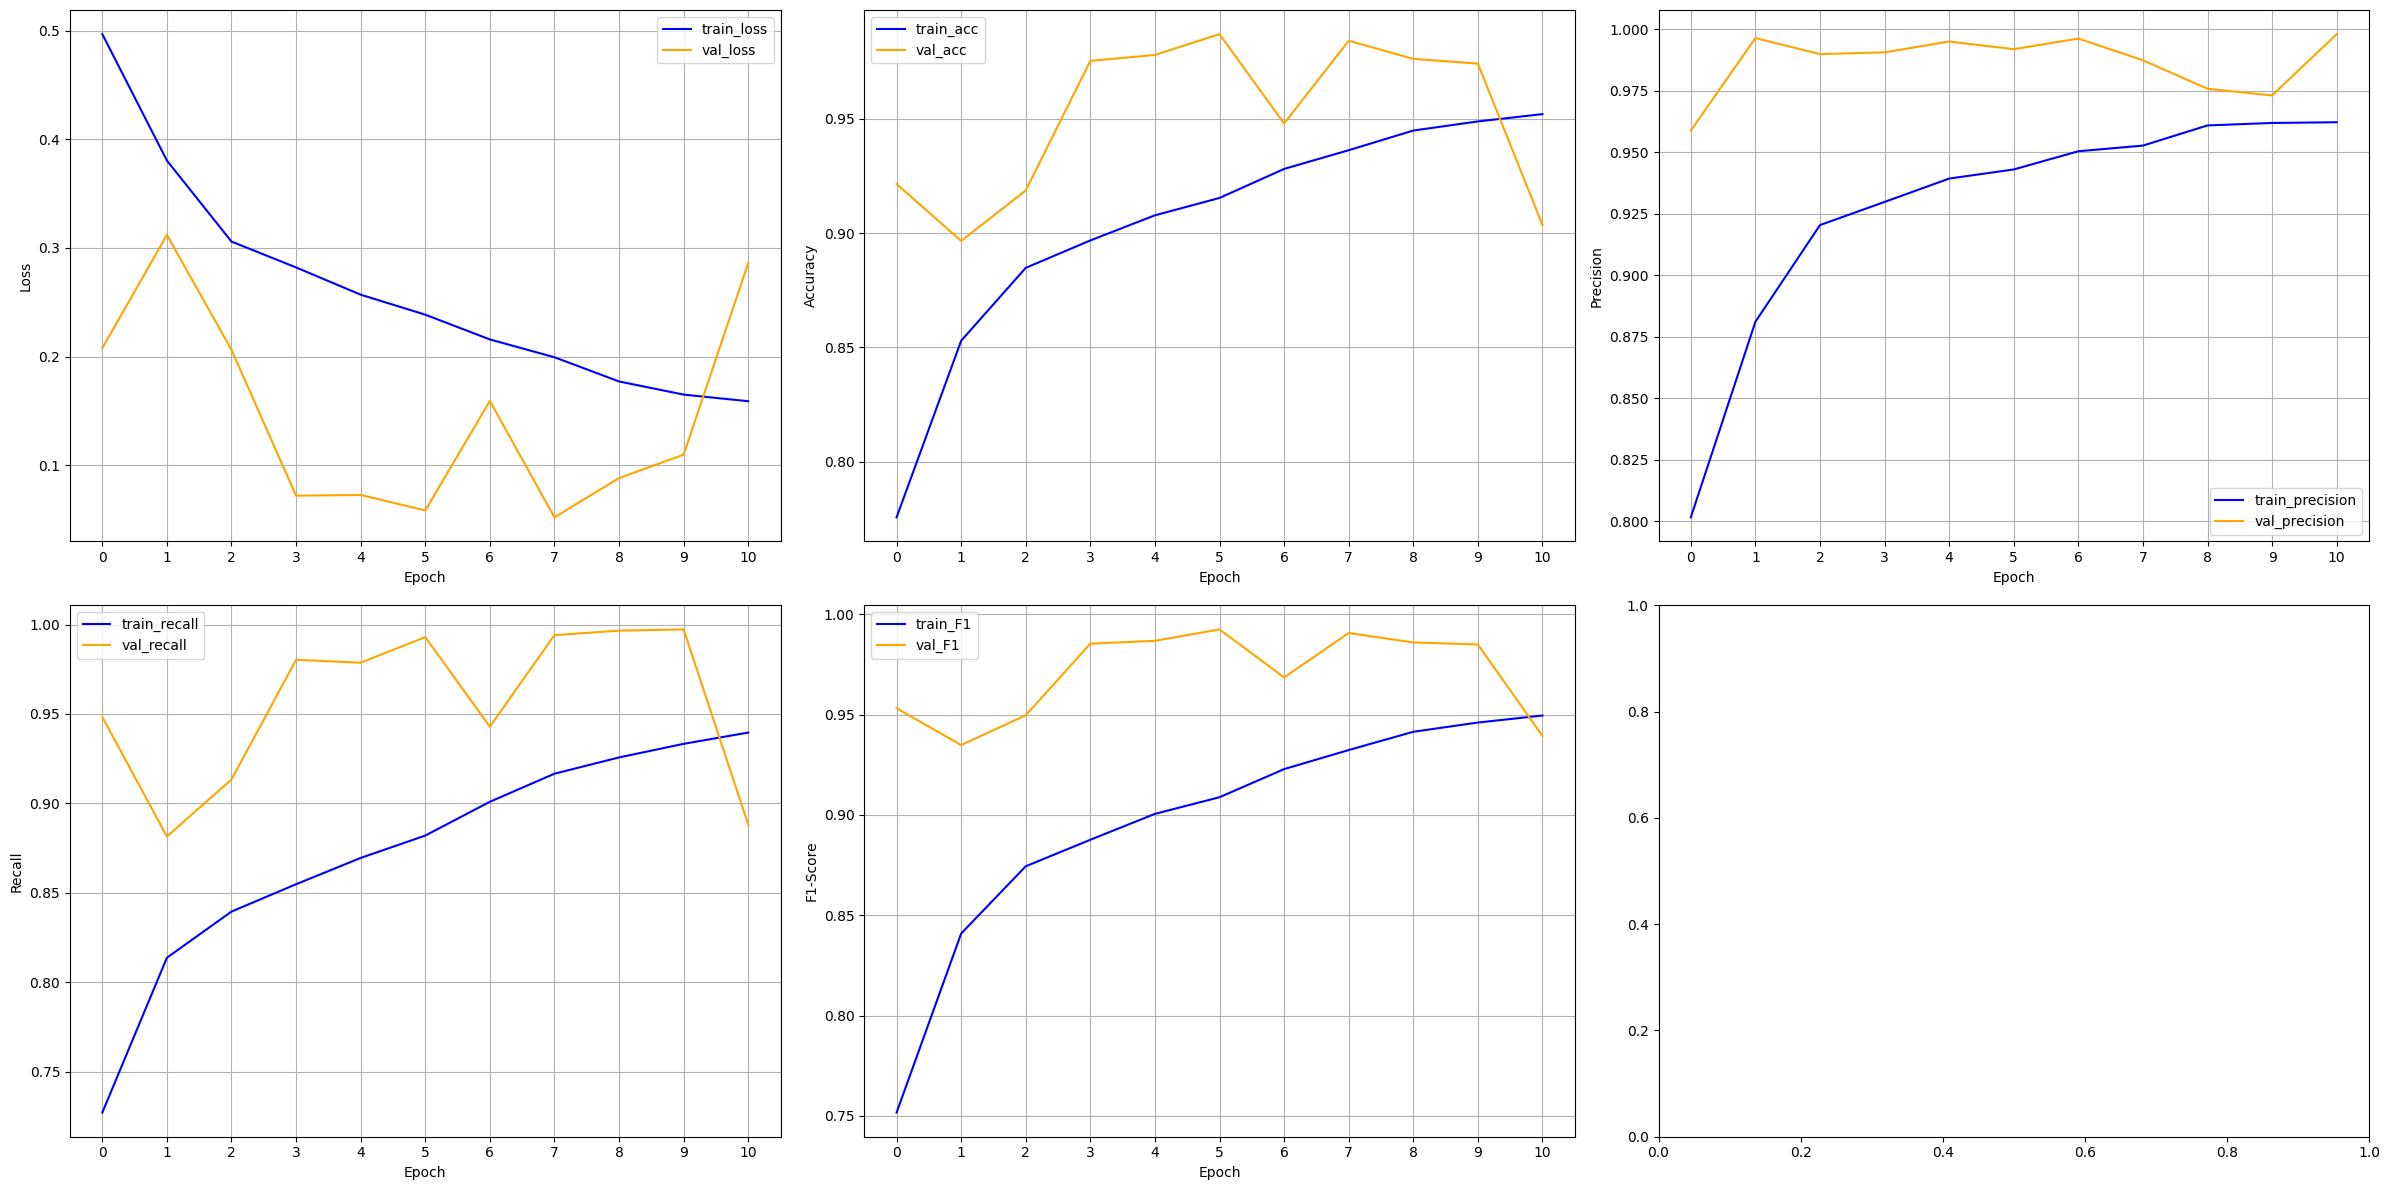

In [ ]:
# Showing the performance metrics obtained by the best performing model
plot_metrics(best_model_metrics)

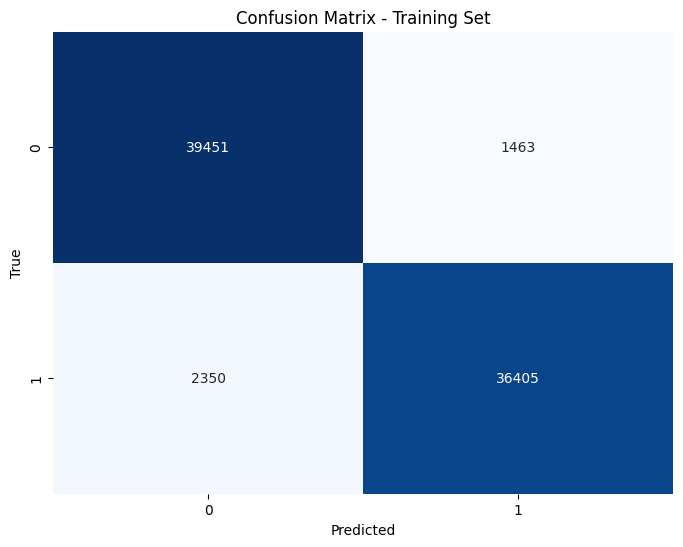

Training Accuracy: 0.9521, Precision: 0.9614, Recall: 0.9394, F1 Score: 0.9502


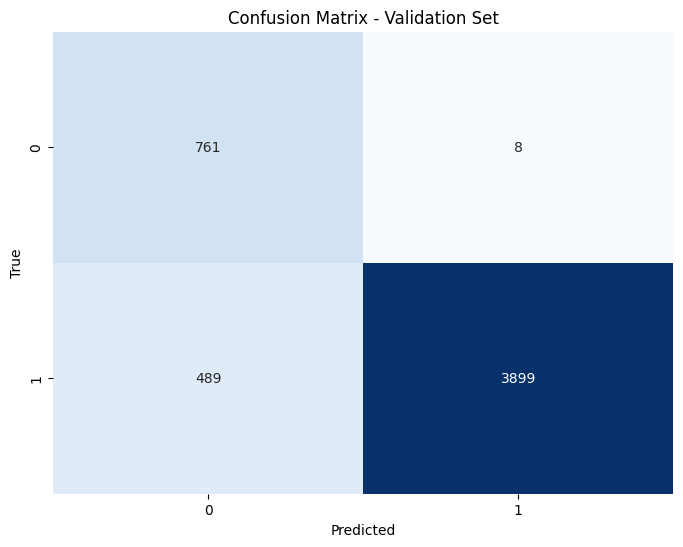

Validation Accuracy: 0.9036, Precision: 0.9980, Recall: 0.8886, F1 Score: 0.9401


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion Matrix for Training Set
cm_train = confusion_matrix(best_train_labels, best_train_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print performance metrics for both training and validation sets
accuracy_train = accuracy_score(best_train_labels, best_train_preds)
precision_train = precision_score(best_train_labels, best_train_preds)
recall_train = recall_score(best_train_labels, best_train_preds)
f1_train = f1_score(best_train_labels, best_train_preds)

print(f"Training Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")

# Confusion Matrix for Validation Set
cm_val = confusion_matrix(best_val_labels, best_val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy_val = accuracy_score(best_val_labels, best_val_preds)
precision_val = precision_score(best_val_labels, best_val_preds)
recall_val = recall_score(best_val_labels, best_val_preds)
f1_val = f1_score(best_val_labels, best_val_preds)


print(f"Validation Accuracy: {accuracy_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")


## 6... Testing

### 6.1 Start testing

In [ ]:
for fold in fold_data:
  X_test_record = fold['test']['X']
  y_test_record = fold['test']['y']

In [ ]:
# Test Set Transformation
if modeltype == 'CNN':
  test_loader, _ = transform(X_test_record, X_test_record, y_test_record, y_test_record, batchfirst=False, batch_size=64)
else:
  test_loader, _ = transform(X_test_record, X_test_record, y_test_record, y_test_record, batchfirst=True, batch_size=64)

# Testing
if modeltype == 'LSTM':
  test_loss, test_acc,train_prec, train_rec,train_F1,test_label, test_pred = evaluate(test_loader, best_model, criterion, device, unsqueeze=False)
else:
  test_loss, test_acc,train_prec, train_rec,train_F1,test_label, test_pred = evaluate(test_loader, best_model, criterion, device, unsqueeze=True)

print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f},Test Precision {train_prec:.4f}, Test Recall {train_rec:.4f}, Test F1 {train_F1:.4f}")

(Trainset) Data shape: torch.Size([64, 800, 1]), targets shape: torch.Size([64])
(Testset) Data shape: torch.Size([64, 800, 1]), targets shape: torch.Size([64])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Final Test Loss: 0.8272, Test Accuracy: 0.7337,Test Precision 0.9362, Test Recall 0.7395, Test F1 0.8246


### 6.2 Visualize the performance of best model in testing

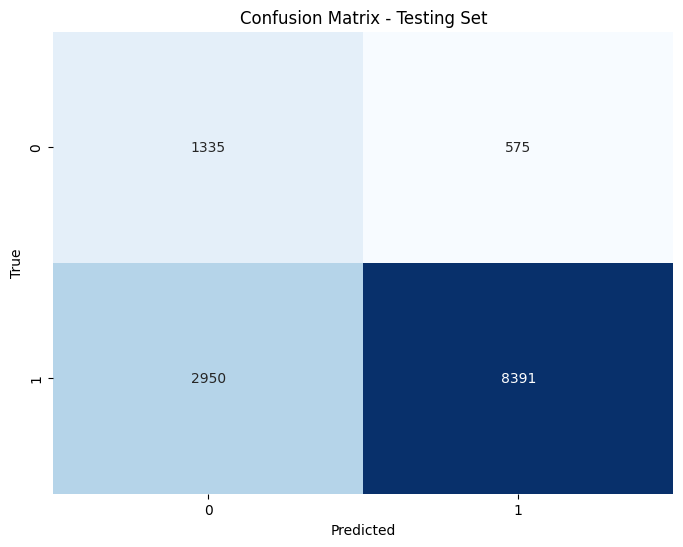

Accuracy: 0.7339823409553996
Precision: 0.9358688378318091
Recall: 0.7398818446345119
F1 Score: 0.8264145368592111


In [ ]:
# test_label = np.concatenate(test_label)
# test_pred = np.concatenate(test_pred)

cm = confusion_matrix(test_label, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(test_label, test_pred )
precision = precision_score(test_label, test_pred )
recall = recall_score(test_label, test_pred )
f1 = f1_score(test_label, test_pred )

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## 7... Save best model's parameter

In [ ]:
if split == 'Intra':
    mode = 'intra'
    if (modeltype == 'LSTM') or (modeltype == 'GRU'):
        torch.save(best_model.state_dict(), f'/content/gdrive/MyDrive/FYP_ECG/{fold}fold_{mode}_{direction}_{modeltype}_state_dict_{best_epochs}.pth')
    else:
        torch.save(best_model.state_dict(), f'/content/gdrive/MyDrive/FYP_ECG/{fold}fold_{mode}_{modeltype}_state_dict_{best_epochs}.pth')
else:
    mode = 'inter'
    if (modeltype == 'LSTM') or (modeltype == 'GRU'):
        torch.save(best_model.state_dict(), f'/content/gdrive/MyDrive/FYP_ECG/{fold}fold_{mode}_{direction}_{modeltype}_state_dict_{best_epochs}.pth')
    else:
        torch.save(best_model.state_dict(), f'/content/gdrive/MyDrive/FYP_ECG/{fold}fold_{mode}_{modeltype}_state_dict_{best_epochs}.pth')